# Experimenting with EDA and Modeling 

To start off, I'm going to focus all efforts on just NY. Once everything is up and running, I'll scale up to all 50 states.

In [963]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pymongo
from pprint import pprint
%load_ext autoreload
%autoreload 2
%matplotlib inline
sns.set_style('whitegrid')

import helper_functions
import plotly.express as px
import plotly.graph_objects as go
from plotly import subplots

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### First off, connect to MongoDB

In [4]:
client = pymongo.MongoClient('mongodb://localhost/')
db = client.admin

# Issue the serverStatus command and print the results
serverStatusResult=db.command("serverStatus")
pprint(serverStatusResult)

mydb = client['energy_data']


{'asserts': {'msg': 0, 'regular': 0, 'rollovers': 0, 'user': 25, 'warning': 0},
 'connections': {'active': 1,
                 'available': 3273,
                 'current': 3,
                 'totalCreated': 16},
 'electionMetrics': {'averageCatchUpOps': 0.0,
                     'catchUpTakeover': {'called': 0, 'successful': 0},
                     'electionTimeout': {'called': 0, 'successful': 0},
                     'freezeTimeout': {'called': 0, 'successful': 0},
                     'numCatchUps': 0,
                     'numCatchUpsAlreadyCaughtUp': 0,
                     'numCatchUpsFailedWithError': 0,
                     'numCatchUpsFailedWithNewTerm': 0,
                     'numCatchUpsFailedWithReplSetAbortPrimaryCatchUpCmd': 0,
                     'numCatchUpsSkipped': 0,
                     'numCatchUpsSucceeded': 0,
                     'numCatchUpsTimedOut': 0,
                     'numStepDownsCausedByHigherTerm': 0,
                     'priorityTakeover': {'c

In [5]:
print(client.list_database_names())

['admin', 'config', 'energy_data', 'local']


In [6]:
energy_collection = mydb['energy_data']

## Get NY Data, group the data by sector, including total (renewable vs. nonrenewable)

In [473]:
ny = [x for x in energy_collection.find({'state':'New York'})]

In [937]:
# Generate list of the possible sectors to iterate through
sectors = [series.get('sector') for series in ny]
sectors = list(set(sectors))
sectors.remove(None)
sectors.sort()

renewable_sources = [
    'Biomass',
    'Fuel Ethanol excluding Denaturant',
    'Geothermal',
    'Hydroelectricity',
    'Solar Energy',
    'Wind Energy',
    'Renewable Sources'
    ]

nonrenewable_sources = [
    'All Petroleum Products',
    'Coal',
    'Natural Gas including Supplemental Gaseous Fuels',
    'Nuclear Power',
    'Nonrenewable Sources'
]

In [723]:
print(sectors)

['Commercial Sector', 'Electric Power Sector', 'Industrial Sector', 'Residential Sector', 'Total All Sectors', 'Total End-Use Sectors', 'Transportation Sector']


### Make combined Dataframes for each NY sector

In [488]:
# Create a dictionary containing all of NY's dataframes
dataframes = {sector: helper_functions.get_energy_pop_df(ny,sector) for sector in sectors}

# Create a dataframe with just the temperature data
temp_df = helper_functions.get_weather_df(ny)

# Concatenate all these bad boys
for sector in dataframes:
    dataframes[sector] = pd.concat([dataframes[sector], temp_df],axis=1)

# Visualize NY Renewable vs. Nonrenewable Energy Consumption Across Different Sectors

In [930]:
for sector in sectors:
    
    plot_df = dataframes[sector]
    
    fig = go.Figure()
    
    fig.add_trace(go.Scatter(
        x=plot_df.index,        
        y=plot_df['Nonrenewable Sources'],           
        mode='lines',           
        name='Nonrenewable',
        line_color='#6785be'
        )
    )
    
    fig.add_trace(go.Scatter(
        x=plot_df.index,               
        y=plot_df['Renewable Sources'],                
        mode='lines',               
        name='Renewable',        
        line_color='#f8432d'
        )
    )
    
    
    fig.update_layout(
        title = f'NY Energy Consumption - {sector}',
        template = "plotly_white",
        xaxis_title = 'Year',
        yaxis_title = 'Energy Consumption (Billion Btu)',
        yaxis_showgrid=False,
        xaxis_showgrid=False,
        yaxis_ticks='outside',
        yaxis_tickcolor='white',
        yaxis_ticklen=10,
        yaxis_zeroline=False,
        width = 1000, #1000
        height = 400  #600      
        )
    fig.show()
    filename=sector.lower().replace(' ','_')
#     fig.write_image(f'figures/ny_{filename}_comparison.png',scale=2)

In [935]:
e_columns = dataframes['Total All Sectors'].columns[1:14]

## Breaking down "All Sectors" by Energy Source

In [947]:
# fig = subplots.make_subplots(rows=3,cols=2)
fig1 = go.Figure()

for column in nonrenewable_sources:

    plot_df = dataframes['Total All Sectors']

    fig1.add_trace(go.Scatter(
        x=plot_df.index,        
        y=plot_df[column],           
        mode='lines',           
        name=re.findall('(\w* ?\w*)',column)[0],
#                 line_color='#6785be'
        )
    )


fig1.update_layout(
    title = 'NY Nonrenewable Energy Consumption - Total All Sectors',
    template = "plotly_white",
    xaxis_title = 'Year',
    yaxis_title = 'Energy Consumption (Billion Btu)',
    yaxis_showgrid=False,
    xaxis_showgrid=False,
    yaxis_ticks='outside',
    yaxis_tickcolor='white',
    yaxis_ticklen=10,
    yaxis_zeroline=False,
#     legend=go.layout.Legend(x=0.83,y=1.1),
    width = 1000, #1000
    height = 600  #600      
    )
fig2 = go.Figure()

for column in renewable_sources:

    plot_df = dataframes['Total All Sectors']

    fig2.add_trace(go.Scatter(
        x=plot_df.index,        
        y=plot_df[column],           
        mode='lines',           
        name=re.findall('(\w* ?\w*)',column)[0],
#                 line_color='#6785be'
        )
    )


fig2.update_layout(
    title = 'NY Renewable Energy Consumption - Total All Sectors',
    template = "plotly_white",
    xaxis_title = 'Year',
    yaxis_title = 'Energy Consumption (Billion Btu)',
    yaxis_showgrid=False,
    xaxis_showgrid=False,
    yaxis_ticks='outside',
    yaxis_tickcolor='white',
    yaxis_ticklen=10,
    yaxis_zeroline=False,
    width = 1000, #1000
    height = 600  #600      
    )

fig1.show()
fig2.show()
# filename=sector.lower().replace(' ','_')
fig1.write_image(f'figures/ny_nr_breakdown.png',scale=2)
fig2.write_image(f'figures/ny_r_breakdown.png',scale=2)
    

##  Breaking down Renewable and Nonrenewable by Sector

In [950]:
fig1 = go.Figure()

for sector in sectors:

    plot_df = dataframes[sector]

    fig1.add_trace(go.Scatter(
        x=plot_df.index,        
        y=plot_df['Nonrenewable Sources'],           
        mode='lines',           
        name=sector,
#                 line_color='#6785be'
        )
    )


fig1.update_layout(
    title = 'NY Nonrenewable Energy Consumption Across Sectors',
    template = "plotly_white",
    xaxis_title = 'Year',
    yaxis_title = 'Energy Consumption (Billion Btu)',
    yaxis_showgrid=False,
    xaxis_showgrid=False,
    yaxis_ticks='outside',
    yaxis_tickcolor='white',
    yaxis_ticklen=10,
    yaxis_zeroline=False,
#     legend=go.layout.Legend(x=0.83,y=1.1),
    width = 1000, #1000
    height = 600  #600      
    )
fig2 = go.Figure()

for sector in sectors:

    plot_df = dataframes[sector]

    fig2.add_trace(go.Scatter(
        x=plot_df.index,        
        y=plot_df['Renewable Sources'],           
        mode='lines',           
        name=sector,
#                 line_color='#6785be'
        )
    )


fig2.update_layout(
    title = 'NY Renewable Energy Consumption Across Sectors',
    template = "plotly_white",
    xaxis_title = 'Year',
    yaxis_title = 'Energy Consumption (Billion Btu)',
    yaxis_showgrid=False,
    xaxis_showgrid=False,
    yaxis_ticks='outside',
    yaxis_tickcolor='white',
    yaxis_ticklen=10,
    yaxis_zeroline=False,
    width = 1000, #1000
    height = 600  #600      
    )

fig1.show()
fig2.show()
# filename=sector.lower().replace(' ','_')
# fig1.write_image(f'figures/ny_nr_breakdown.png',scale=2)
# fig2.write_image(f'figures/ny_r_breakdown.png',scale=2)a

In [956]:
import plotly
plotly.offline.plot(fig1, filename='nonrenewables.html')

'nonrenewables.html'

# Visualize NY Nonrenewable Energy Consumption Across Decades - All Sectors

In [563]:
total_df = dataframes['Total All Sectors']

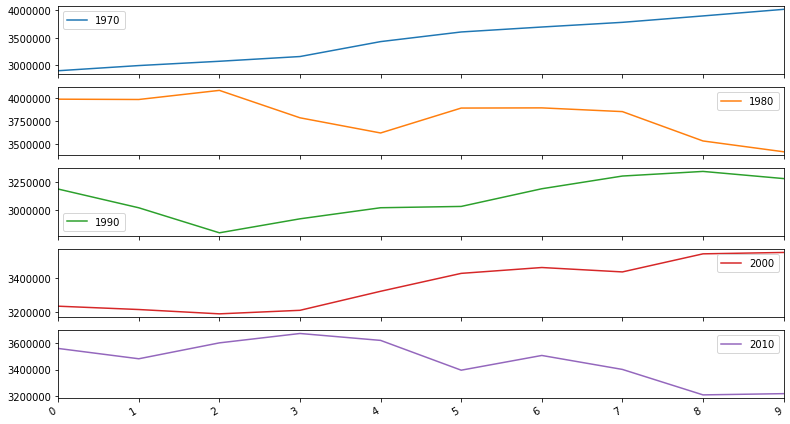

In [469]:
# Use pandas grouper to group values using annual frequency
nr_decade_groups = total_df['Nonrenewable Sources'].groupby(pd.Grouper(freq ='10Y'))

# Create a new DataFrame and store yearly values in columns 
nr_total_decades = pd.DataFrame()

for yr, group in nr_decade_groups:
    if yr.year > 1960 and yr.year < 2011:
        nr_total_decades[yr.year] = group.values
        

# Visualize NY Renewable Energy Consumption Across Decades - All Sectors

In [471]:
decades_melt = nr_total_decades.reset_index().melt(id_vars = 'index',
                                  value_vars = nr_total_decades.columns,
                                  var_name = 'Decade',
                                  value_name = 'Energy Consumed (Billion Btu)')

decades_melt.columns = ['Year Within Decade', 'Decade', 'Energy Consumed (Billion Btu)'] 

fig = px.line(decades_melt,
              x = decades_melt['Year Within Decade'],
              y = decades_mel['Energy Consumed (Billion Btu)'],
              color = 'Decade',
              title = 'New York Nonrenewable Energy Consumption - Total All Sectors')
fig

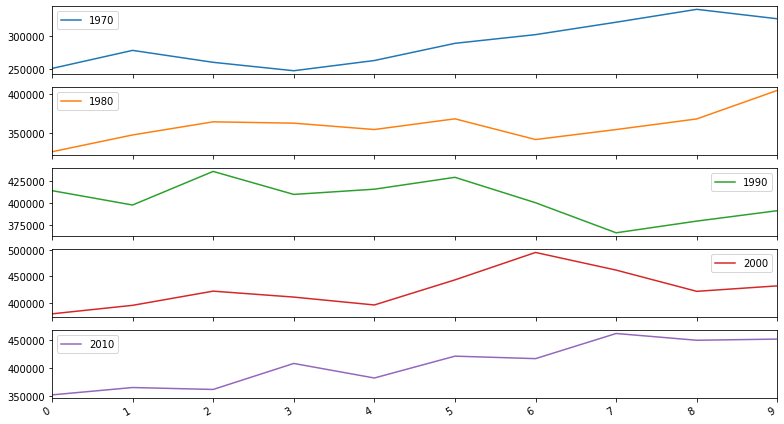

In [500]:
# Use pandas grouper to group values using annual frequency
r_decade_groups = total_df['Renewable Sources'].groupby(pd.Grouper(freq ='10Y'))

# Create a new DataFrame and store yearly values in columns 
r_total_decades = pd.DataFrame()

for yr, group in r_decade_groups:
    if yr.year > 1960 and yr.year < 2011:
        r_total_decades[yr.year] = group.values
        

# Plot the yearly groups as subplots
r_total_decades.plot(figsize = (13,8), subplots=True);

In [501]:
r_decades_melt = r_total_decades.reset_index().melt(id_vars = 'index',
                                  value_vars = r_total_decades.columns,
                                  var_name = 'Decade',
                                  value_name = 'Energy Consumed (Billion Btu)')

r_decades_melt.columns = ['Year Within Decade', 'Decade', 'Energy Consumed (Billion Btu)'] 

fig = px.line(r_decades_melt,
              x = 'Year Within Decade',
              y = 'Energy Consumed (Billion Btu)',
              color = 'Decade',
              title = 'New York Renewable Energy Consumption - Total All Sectors')
fig

# Visualize NY Temperature Data

In [787]:
fig = go.Figure()

for column in temp_df.columns[3:-14]:

    fig.add_trace(go.Scatter(
        x=temp_df.index,        
        y=temp_df[column],           
        mode='lines',           
        name=column.title().replace('_',' ')+'F',
#         line_color='#6785be'
        )
    )
    
fig.update_layout(
    title = 'NY Temperature Trends',
    template = "plotly_white",
    xaxis_title = 'Year',
    yaxis_title = 'No. of Days per Year',
    yaxis_showgrid=False,
    xaxis_showgrid=False,
    yaxis_ticks='outside',
    yaxis_tickcolor='white',
    yaxis_ticklen=10,
    yaxis_zeroline=False,
    width = 1200, 
    height = 600  #600      
    )
fig.write_image('figures/ny_temp_trends.png',scale=2) 

In [498]:
fig = px.line(temp_df_melt, 
              x = 'Year', 
              y = 'Temperature', 
              color = 'Temperature Cutoff',
              title='New York Temperature Trends',
              height = 600,
              width = 1000)

fig.show()

In [786]:
fig = go.Figure()

for column in temp_df.columns[-4:]:

    fig.add_trace(go.Scatter(
        x=temp_df.index,        
        y=temp_df[column],           
        mode='lines',           
        name=column.title().replace('_',' '),
#         line_color='#6785be'
        )
    )
    
fig.update_layout(
    title = 'NY Temperature Statistics',
    template = "plotly_white",
    xaxis_title = 'Year',
    yaxis_title = 'Temperature (F)',
    yaxis_showgrid=False,
    xaxis_showgrid=False,
    yaxis_ticks='outside',
    yaxis_tickcolor='white',
    yaxis_ticklen=10,
    yaxis_zeroline=False,
    width = 1200, 
    height = 600  #600      
    )

fig.write_image('figures/ny_temp_stats.png',scale=2) 

# Histograms

Using to show that due to the nature of linear statistical modeling and time series, we can only select data with normally distributed variables. We thus should only focus predictions for each state on renewable vs. nonrenewable energy in **Total All Sectors**. 

In [962]:
for sector in sectors:
    plot_df = dataframes[sector]
    
    fig = go.Figure()
    
    fig.add_trace(go.Histogram(
        x=plot_df['Renewable Sources'],
        name='Renewable',
        histnorm='probability'),
        )
    
    fig.add_trace(go.Histogram(
        x=plot_df['Nonrenewable Sources'],
        name='Nonrenewable',
        histnorm='probability')
        )
    
    fig.update_layout(height=500, 
                      width=1000, 
                      template = "plotly_white",
                      title = sector,
                      xaxis_title='Energy Consumption (Billion Btu)',
                      barmode='overlay'
                      )
    fig.update_traces(opacity=0.75)
    
    fig.show()
    filename=sector.lower().replace(' ','_')
#     fig.write_image(f'figures/ny_{filename}_hist.png',scale=2)
    


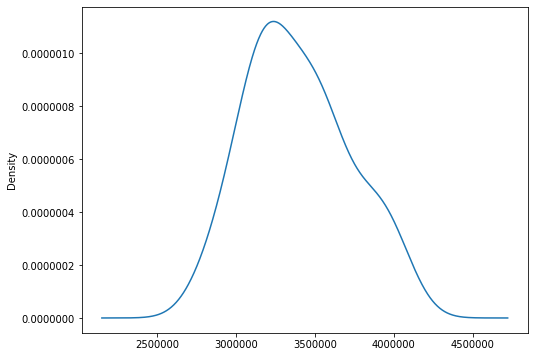

In [524]:
total_df['Nonrenewable Sources'].plot(kind='kde', figsize = (8,6));

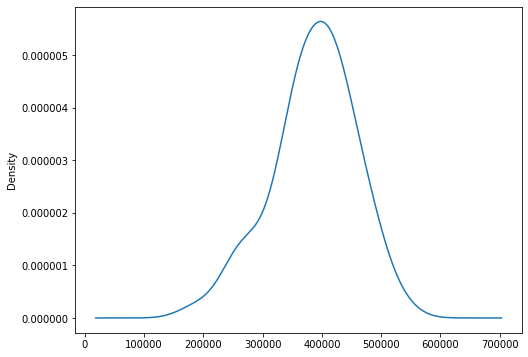

In [525]:
total_df['Renewable Sources'].plot(kind='kde', figsize = (8,6));

In [855]:
exo_columns = list(total_df.columns[17:26]) + list(total_df.columns[-4:])

In [856]:
exo_columns

['days_above_85',
 'days_above_80',
 'days_above_75',
 'days_above_70',
 'days_below_70',
 'days_below_65',
 'days_below_60',
 'days_below_55',
 'days_below_50',
 'Max Temp',
 'Min Temp',
 'Mean Temp',
 'Std Temp']

In [872]:
fig = subplots.make_subplots(rows=3,
                             cols=5,
                             subplot_titles=[column.replace('_',' ').title() for column in  exo_columns],
                            shared_yaxes=True)

fig.update_layout(height=800, 
                      width=1400, 
                      template = "plotly_white",
                      title = 'Temperature Frequency Distributions',
                      )

for index in range(len(exo_columns)):
    
    if index > 8:
        xaxis_label = 'Temperature (F)'
    else:
        xaxis_label = 'No. of Days per Year'
    
    row = (index // 5) + 1
    col = index % 5 + 1
    
#     print(index, row, col)
    
    fig.add_trace(go.Histogram(
        
        x=temp_df[exo_columns[index]],
        showlegend=False,
        marker_color='#3c19f0'),
        col=col,row=row,
        )

    # Update xaxis properties
    fig.update_xaxes(title_text=xaxis_label, 
                     showgrid=False, 
                     zeroline=False,ticks='outside',
                      tickcolor='white',
                      ticklen=10,
                     row=row, col=col)

    # Update yaxis properties
    
    fig.update_yaxes(showgrid=False,
                     zeroline=False,ticks='outside',
                      tickcolor='white',
                      ticklen=10, 
                     row=row, col=col)
    if col == 1:
        fig.update_yaxes(title_text='Frequency',row=row, col=col)
    
fig.show()
filename=sector.lower().replace(' ','_')
fig.write_image('figures/ny_temp_hists.png',scale=2)

In [901]:
fig = subplots.make_subplots(cols=2,
                           subplot_titles=['NY Population','NY Population Frequency Distribution'])

fig.add_trace(go.Scatter(
    x=total_df.index,
    y=total_df['Population'],
    showlegend=False),
         row=1,col=1
                        )
fig.add_trace(go.Histogram(
    x=total_df['Population'],
    nbinsx=18,
    showlegend=False),
                      row=1,col=2)

fig.update_layout(
    width = 1300, #1000
    height = 500  #600  
              )

# Update xaxis properties
fig.update_xaxes(title_text='Year', 
                 showgrid=False, 
                 zeroline=False,ticks='outside',
                  tickcolor='white',
                  ticklen=10,
                 row=1, col=1)
fig.update_xaxes(title_text='Population', 
                 showgrid=False, 
                 zeroline=False,ticks='outside',
                  tickcolor='white',
                  ticklen=10,
                row=1, col=2)
# Update yaxis properties

fig.update_yaxes(showgrid=False,
                 zeroline=False,ticks='outside',
                  tickcolor='white',
                  ticklen=10, 
                 row=1, col=1)


fig.update_yaxes(showgrid=False,
                 zeroline=False,ticks='outside',
                  tickcolor='white',
                  ticklen=10, 
                 row=1, col=2)
   
        
fig.show()
fig.write_image('figures/ny_pop_fig.png',scale=2)

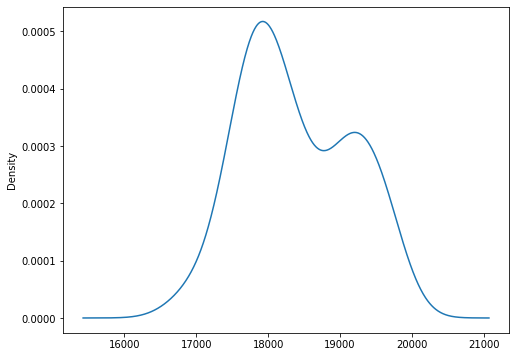

In [593]:
total_df['Population'].plot(kind='kde', figsize = (8,6));

In [824]:
2%4

2

In [859]:
temp_df.columns

Index(['days_above_100', 'days_above_95', 'days_above_90', 'days_above_85',
       'days_above_80', 'days_above_75', 'days_above_70', 'days_below_70',
       'days_below_65', 'days_below_60', 'days_below_55', 'days_below_50',
       'days_below_45', 'days_below_40', 'days_below_35', 'days_below_30',
       'days_below_25', 'days_below_20', 'days_below_15', 'days_below_10',
       'days_below_5', 'Max Temp', 'Min Temp', 'Mean Temp', 'Std Temp'],
      dtype='object')

For the most part, none of these variables are normally distributed. Population seems to be bivariate interestingly. So maybe that will not be such a great predictor in the final model.

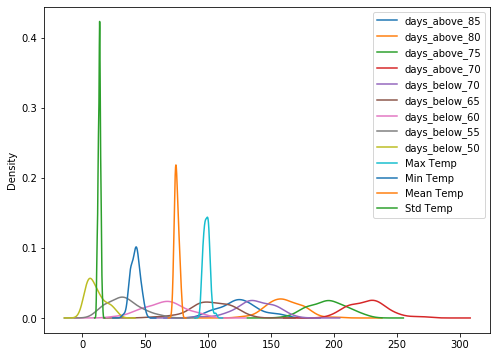

In [592]:
total_df[exo_columns[1:]].plot(kind='kde', figsize = (8,6));

# Summarize Findings So Far

1. New York nonrenewable energy consumption is/has much been much greater than its renewable counterpart throughout history
2. It appears that the trend over the last 20 years is that nonrenewable consumption is decreasing, while renewable consumption is increasing - many factors likely involving awareness of climate change, legislation, decreasing prices of renewable energy sources.
3. Histograms/KDE plots of energy consumption show that of all sectors, only the aggregated sector of "Total All Sectors" exhibits normally distributed energy consumption across renewable and nonrenewable energy. We'll therefore limit the scope of any forecasting to "Total All Sectors" for any state moving forward.
4. Histograms/KDE plots of exogenous variables show that pretty much all temperature designations exhibit normal, or mostly normal frequency distributions. Thus, all of these are fair game for the model.
5. Histogram/KDE plot of population reveals a bivariate distribution, which may be an issue going forward.

I dont think any logarithmic transformations will help here, but scaling will be necessary before training a model.

# Testing Stationarity

In [596]:
r_ts = total_df['Renewable Sources']
nr_ts = total_df['Nonrenewable Sources']

r_roll_mean = r_ts.rolling(window=6, center=False).mean()
r_roll_std = r_ts.rolling(window=6, center=False).std()

nr_roll_mean = nr_ts.rolling(window=6, center=False).mean()
nr_roll_std = nr_ts.rolling(window=6, center=False).std()

In [869]:
# Create traces
fig = subplots.make_subplots(rows = 2, 
                             cols = 1,
                             vertical_spacing = 0.15,
                             subplot_titles = ['NY Renewable Energy Consumption Rolling Mean & Standard Deviation', 
                                               'NY Nonrenewable Energy Consumption Rolling Mean & Standard Deviation'])

fig.add_trace(go.Scatter(x=dates[::-1], 
                         y=r_ts,
                         mode='lines',
                         name='Original',
#                          legendgroup = 'r',
                         line_color='#f8432d'
                         ), 
              row = 1,
              col = 1,
             )

fig.add_trace(go.Scatter(x=dates[::-1], 
                         y=r_roll_mean,
                         mode='lines',
                         name='Rolling Mean',
#                          legendgroup = 'r',
                         line_color='#6785be'
                        ),
              row = 1,
              col = 1)

fig.add_trace(go.Scatter(x=dates[::-1], 
                         y=r_roll_std,
                         mode='lines', 
                         name='Rolling Std',
#                          legendgroup = 'r',
                         line_color='rgb(150,150,150)'
                        ),
              row = 1, 
              col = 1)


fig.add_trace(go.Scatter(x=dates[::-1], 
                         y=nr_ts,
                         mode='lines',
                         name='Original',
                         showlegend=False,
                         line_color='#f8432d'),
              row = 2,
              col = 1)

fig.add_trace(go.Scatter(x=dates[::-1], 
                         y=nr_roll_mean,
                         mode='lines',
                         name='Rolling Mean',
                         showlegend=False,
                         line_color='#6785be'),
              row = 2,
              col = 1)

fig.add_trace(go.Scatter(x=dates[::-1], 
                         y=nr_roll_std,
                         mode='lines',
                         name='Rolling Std',
                         showlegend=False,
                         line_color='rgb(150,150,150)'),
              row = 2,
              col = 1)

fig.update_layout(height=800, 
                  width=1000, 
                  template = "plotly_white",
                  )


# Update xaxis properties
fig.update_xaxes(title_text='Year', 
                 showgrid=False, 
                 zeroline=False, 
#                  ticks='outside',
#                  tickcolor='white',
#                  ticklen=10, 
                 row=1, col=1)

fig.update_xaxes(title_text='Year', 
                 showgrid=False, 
                 zeroline=False, 
#                  ticks='outside',
#                  tickcolor='white',
#                  ticklen=10, 
                 row=2, col=1)


# Update yaxis properties
fig.update_yaxes(title_text='Energy Consumption (Billion Btu)', 
                 showgrid=False,
                 ticks='outside',
                 tickcolor='white',
                 ticklen=10,
                 zeroline=False, row=1, col=1)
fig.update_yaxes(title_text='Energy Consumption (Billion Btu)', 
                 showgrid=False,
                 ticks='outside',
                 tickcolor='white',
                 ticklen=10,
                 zeroline=False, 
                 row=2, col=1)


fig.show()

In [870]:
import os

if not os.path.exists("figures"):
    os.mkdir("figures")
    
fig.write_image("figures/rolling_stats.png",scale=2)

#### The rolling means for both of the above graphs are not constant over time, indicating that our series are not stationary. Below is a Dickey-Fuller test to confirm with statistical confidence.

In [964]:
def dickey_fuller_comparison(r_ts, nr_ts):
    """
    Returns a df with dickey fuller results for both the renewable and nonrenewable time series.
    
    Param r_ts: [pd.Series] time series of renewable energy
    Param nr_ts: [pd.Series] time series of nonrenewable energy
    """

    r_dftest = adfuller(r_ts)
    r_dfoutput = pd.Series(r_dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key,value in r_dftest[4].items():
        r_dfoutput['Critical Value (%s)'%key] = value

    nr_dftest = adfuller(nr_ts)
    nr_dfoutput = pd.Series(nr_dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key,value in nr_dftest[4].items():
        nr_dfoutput['Critical Value (%s)'%key] = value

    df_results = pd.concat([r_dfoutput, nr_dfoutput],axis=1)
    df_results.columns = ['Renewable Sources', 'Nonrenewable Sources']
    
    return df_results

In [965]:
dickey_fuller_comparison(r_ts, nr_ts)

,Renewable Sources,Nonrenewable Sources
Test Statistic,-0.378808,-2.296522
p-value,0.913577,0.173092
#Lags Used,11.000000,1.000000
Number of Observations Used,46.000000,56.000000
Critical Value (1%),-3.581258,-3.552928
Critical Value (5%),-2.926785,-2.914731
Critical Value (10%),-2.601541,-2.595137


Using 1% critical value, we find that both test statistics are greater than the critical value and thus fail to reject the null hypothesis. Therefore, both time series exhibit non-stationary behavior.

## Decomposition 

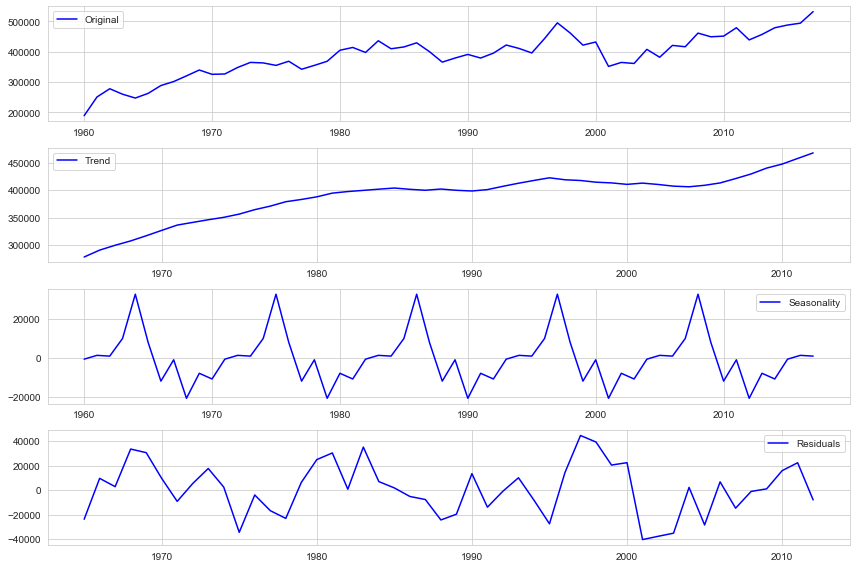

In [985]:
r_decomposition = seasonal_decompose(r_ts,freq=11)
nr_decomposition = seasonal_decompose(np.log(nr_ts))

# Gather the trend, seasonality, and residuals 
r_trend = r_decomposition.trend
r_seasonal = r_decomposition.seasonal
r_residual = r_decomposition.resid

nr_trend = nr_decomposition.trend
nr_seasonal = nr_decomposition.seasonal
nr_residual = nr_decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(r_ts, label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(r_trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(r_seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(r_residual, label='Residuals', color='blue')
plt.legend(loc='best')
plt.tight_layout()